[LSTM](https://d2l.ai/chapter_recurrent-modern/lstm.html)

Mathematically, suppose that there are $h$ hidden units, the batch size is $n$, and the number of inputs is $d$. Thus, the input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Correspondingly, the gates at time step $t$ are defined as follows: the input gate is $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, the forget gate is $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, and the output gate is $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. They are calculated as follows:
$$
\begin{aligned}
\mathbf{I}_t & =\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xi}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hi}}+\mathbf{b}_{\mathrm{i}}\right), \\
\mathbf{F}_t & =\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xf}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hf}}+\mathbf{b}_{\mathrm{f}}\right), \\
\mathbf{O}_t & =\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xo}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{ho}}+\mathbf{b}_{\mathrm{o}}\right),
\end{aligned}
$$
where $\mathbf{W}_{\text {xi }}, \mathbf{W}_{\text {xf }}, \mathbf{W}_{\text {xo }} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\text {hi }}, \mathbf{W}_{\mathrm{hf}}, \mathbf{W}_{\text {ho }} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_{\mathrm{i}}, \mathbf{b}_{\mathrm{f}}, \mathbf{b}_{\mathrm{o}} \in \mathbb{R}^{1 \times h}$ are bias parameters. Note that broadcasting (see Section 2.1.4) is triggered during the summation. We use sigmoid functions (as introduced in Section 5.1) to map the input values to the interval $(0,1)$.  
Next we design the memory cell. Since we have not specified the action of the various gates yet, we first introduce the input node $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$. Its computation is similar to that of the three gates described above, but uses a tanh function with a value range for $(-1,1)$ as the activation function. This leads to the following equation at time step $t$ :
$$
\tilde{\mathbf{C}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xc}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hc}}+\mathbf{b}_{\mathrm{c}}\right),
$$
where $\mathbf{W}_{\mathrm{xc}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\mathrm{hc}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_{\mathrm{c}} \in \mathbb{R}^{1 \times h}$ is a bias parameter.  
In LSTMs, the input gate $\mathbf{I}_t$ governs how much we take new data into account via $\tilde{\mathbf{C}}_t$ and the forget gate $\mathbf{F}_t$ addresses how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain. Using the Hadamard (elementwise) product operator $\odot$ we arrive at the following update equation:
$$
\mathbf{C}_t=\mathbf{F}_t \odot \mathbf{C}_{t-1}+\mathbf{I}_t \odot \tilde{\mathbf{C}}_t .
$$

If the forget gate is always 1 and the input gate is always 0 , the memory cell internal state $\mathbf{C}_{t-1}$ will remain constant forever, passing unchanged to each subsequent time step. However, input gates and forget gates give the model the flexibility of being able to learn when to keep this value unchanged and when to perturb it in response to subsequent inputs. In practice, this design alleviates the vanishing gradient problem, resulting in models that are much easier to train, especially when facing datasets with long sequence lengths.  
Last, we need to define how to compute the output of the memory cell, i.e., the hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$, as seen by other layers. This is where the output gate comes into play. In LSTMs, we first apply tanh to the memory cell internal state and then apply another point-wise multiplication, this time with the output gate. This ensures that the values of $\mathbf{H}_t$ are always in the interval $(-1,1)$ :
$$
\mathbf{H}_t=\mathbf{O}_t \odot \tanh \left(\mathbf{C}_t\right) .
$$

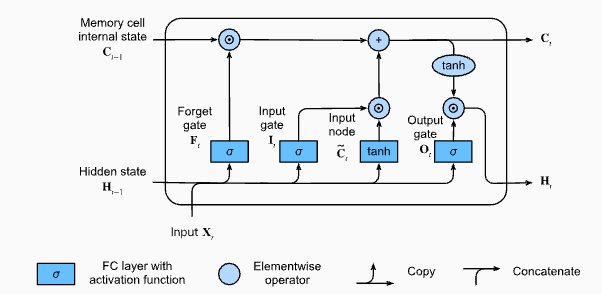

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# GPU
def try_gpu(i=0):
  if torch.cuda.device_count() >= i+1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

In [3]:
def get_params(input, num_hiddens, output, device):
  # Input gate
  W_xi = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hi = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_i = torch.zeros((num_hiddens), device=device)
  # Forget gate
  W_xf = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hf = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_f = torch.zeros((num_hiddens), device=device)
  # Output gate
  W_xo = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_ho = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_o = torch.zeros((num_hiddens), device=device)
  # C_tital
  W_xc = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hc = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_c = torch.zeros((num_hiddens), device=device)
  # output
  W_o = torch.normal(0, 0.01, size=(num_hiddens, output), device=device)
  b_oo = torch.zeros((output), device=device)
  params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_o, b_oo]
  for param in params:
    param.requires_grad_(True)
  return params

In [4]:
def init_state(batch, num_hiddens, device):
  return (torch.zeros((batch, num_hiddens), device=device), torch.zeros((batch, num_hiddens), device=device))

In [5]:
def lstm(X, state, params):
  [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_o, b_oo] = params
  outputs = []
  (H, C) = state
  for x in X:
    I = torch.sigmoid((x @ W_xi) + (H @ W_hi) + b_i)
    F = torch.sigmoid((x @ W_xf) + (H @ W_hf) + b_f)
    O = torch.sigmoid((x @ W_xo) + (H @ W_ho) + b_o)
    C_tital = torch.tanh((x @ W_xc) + (H @ W_hc) + b_c)
    C = F * C + I * C_tital
    H = O * torch.tanh(C)
    y = H @ W_o + b_oo
    outputs.append(y)
  return outputs[-1], (H, C)

In [6]:
class LSTM(nn.Module):
  def __init__(self, input, num_hiddens, output, forward, init, params, device):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.forward = forward
    self.params = params(input, num_hiddens, output, device)
    self.init = init
  def __call__(self, x, state):
    shape = x.shape
    x = x.reshape(shape[0], -1, shape[-1])
    x = x.permute(1, 0, 2)
    return self.forward(x, state, self.params)
  def init_state_(self, batch, device):
    return self.init(batch, self.num_hiddens, device)

In [7]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                       transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 156503827.34it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40351663.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 80863028.75it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21747178.96it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
batch_size = 256
num_epochs = 10
lr = 0.01
net = LSTM(28, 128, 10, lstm, init_state, get_params, try_gpu())

In [9]:
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.params, lr=lr)

In [11]:
from Common import plot_loss_acc, validation_rnn, train_and_test_rnn

Step:100/235, Epoch:1/10, Loss:0.6937
Step:200/235, Epoch:1/10, Loss:0.2738
Step:235/235, Epoch:1/10, Accuracy:0.94
Step:100/235, Epoch:2/10, Loss:0.1257
Step:200/235, Epoch:2/10, Loss:0.1071
Step:235/235, Epoch:2/10, Accuracy:0.97
Step:100/235, Epoch:3/10, Loss:0.0923
Step:200/235, Epoch:3/10, Loss:0.0711
Step:235/235, Epoch:3/10, Accuracy:0.98
Step:100/235, Epoch:4/10, Loss:0.0499
Step:200/235, Epoch:4/10, Loss:0.0564
Step:235/235, Epoch:4/10, Accuracy:0.98
Step:100/235, Epoch:5/10, Loss:0.0667
Step:200/235, Epoch:5/10, Loss:0.0747
Step:235/235, Epoch:5/10, Accuracy:0.98
Step:100/235, Epoch:6/10, Loss:0.1173
Step:200/235, Epoch:6/10, Loss:0.0243
Step:235/235, Epoch:6/10, Accuracy:0.99
Step:100/235, Epoch:7/10, Loss:0.0493
Step:200/235, Epoch:7/10, Loss:0.0079
Step:235/235, Epoch:7/10, Accuracy:0.98
Step:100/235, Epoch:8/10, Loss:0.0246
Step:200/235, Epoch:8/10, Loss:0.0161
Step:235/235, Epoch:8/10, Accuracy:0.99
Step:100/235, Epoch:9/10, Loss:0.0613
Step:200/235, Epoch:9/10, Loss:0.0

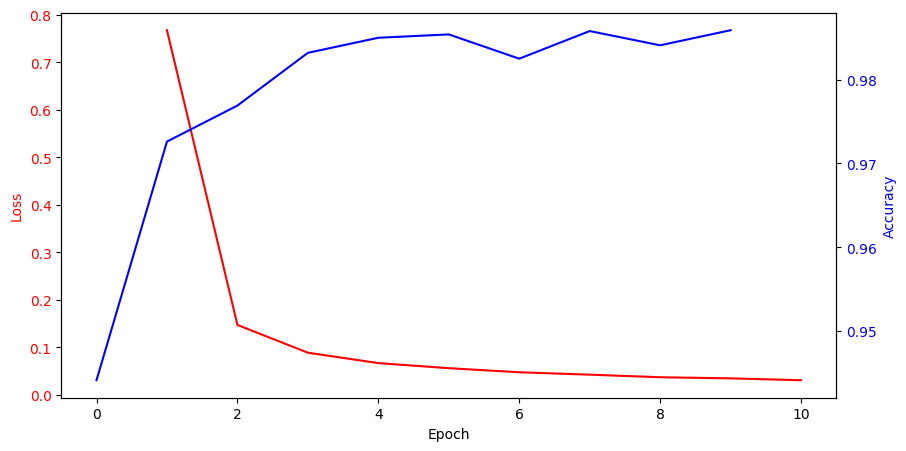

In [12]:
train_and_test_rnn(num_epochs, net, loss, optimizer, validation_rnn, train_loader, test_loader, try_gpu(), figsize=(10, 5))